In [43]:
## Notebook 4:
## Changed Model (30,120,200,120)
## Create new model for every training, train the model as the sliding window for 1 week
## In this notebook we use job history data for Mar - May 2022
## Lookback for queue minutes = 35
## We train the model for one week (i.e 7 days) and then predict queue minutes for the jobs in the 8th day.
## Then we slide the window by one day, and then train again for next 7 days and predict the 8th day
## For every training, we create the same model and do the training from the scratch


In [2]:
import sys
sys.path.append('/home/jovyan/work/')
sys.path.append('/home/jovyan/work/src')
sys.path.append('/home/jovyan/work/src/data')
sys.path.append('/home/jovyan/work/src/data_explore')
sys.path.append('/home/jovyan/work/src/features')
sys.path.append('/home/jovyan/work/src/models')
sys.path.append('/home/jovyan/work/src/analysis')


In [3]:
print(sys.path)

['/home/jovyan/work/notebooks', '/opt/conda/lib/python311.zip', '/opt/conda/lib/python3.11', '/opt/conda/lib/python3.11/lib-dynload', '', '/opt/conda/lib/python3.11/site-packages', '/home/jovyan/work/', '/home/jovyan/work/src', '/home/jovyan/work/src/data', '/home/jovyan/work/src/data_explore', '/home/jovyan/work/src/features', '/home/jovyan/work/src/models', '/home/jovyan/work/src/analysis']


In [4]:
from src import data,data_explore,features
from data import create_input_data
from data_explore import explore_util
from features import build_features
from models import train_model,predict_model
from analysis import analyze_pred

import pandas as pd

In [5]:
def get_jobs_in_range(dfq,start,end):
    df1=dfq.query('submit >= @start and submit < @end')
    return df1

In [6]:
# weekly prediction for the month of March
df_arr={}
df_mar_may = create_input_data.read_data(csv_file_name="../data/processed/lookback35_nnodes_bklogjobs_sw_mar_may31.csv", parse_dates_col=[1,2])
df_mar_may.iloc[130,]
#df_arr['1wee']= get_jobs_in_range(df_feb_aug,"2022-03-01","2022-03-07")
#df_arr['april']= get_jobs_in_range(df_feb_aug,"2022-04-01","2022-05-01")


index                               36173
submit                2022-03-01 03:59:57
start                 2022-03-01 04:00:34
nnodes                                  1
max_minutes                           120
                             ...         
delta_t34                      238.016667
qm35                                 -200
nnodes35                             -200
backlog_num_jobs35                   -200
delta_t35                             0.0
Name: 130, Length: 151, dtype: object

In [7]:
df_mar_may.iloc[131,]

index                               36174
submit                2022-03-01 04:00:42
start                 2022-03-01 04:01:11
nnodes                                  1
max_minutes                           120
                             ...         
delta_t34                          238.75
qm35                                    0
nnodes35                                1
backlog_num_jobs35                    234
delta_t35                      238.766667
Name: 131, Length: 151, dtype: object

In [8]:
df_mar = get_jobs_in_range(df_mar_may.iloc[131:,],"2022-03-01", "2022-04-02")
df_mar

,index,submit,start,nnodes,max_minutes,queue_minutes,backlog_minutes,backlog_num_jobs,running_num_jobs,running_minutes,...,backlog_num_jobs33,delta_t33,qm34,nnodes34,backlog_num_jobs34,delta_t34,qm35,nnodes35,backlog_num_jobs35,delta_t35
131,36174,2022-03-01 04:00:42,2022-03-01 04:01:11,1,120,0,462900,257,20786,8077218,...,235,238.750000,0,1,234,238.750000,0,1,234,238.766667
132,36175,2022-03-01 04:02:28,2022-03-01 04:03:01,1,120,0,462900,257,20786,8077218,...,236,240.500000,0,1,235,240.516667,0,1,234,240.516667
133,36176,2022-03-01 04:03:04,2022-03-01 04:03:37,1,120,0,462900,257,20786,8077218,...,237,241.083333,0,1,236,241.100000,0,1,235,241.116667
134,36177,2022-03-01 04:03:53,2022-03-01 04:04:14,1,120,0,462900,257,20786,8077218,...,238,241.900000,0,1,237,241.900000,0,1,236,241.916667
135,36178,2022-03-01 04:04:37,2022-03-01 04:04:51,1,120,0,461820,256,20786,8077218,...,239,242.616667,0,1,238,242.633333,0,1,237,242.633333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46831,82874,2022-04-01 23:40:41,2022-04-01 23:40:42,1,360,0,4620,36,20889,8099526,...,141,40.183333,29,5,145,41.666667,11,5,145,42.116667
46832,82875,2022-04-01 23:48:18,2022-04-01 23:48:19,5,720,0,4620,36,20889,8099526,...,142,47.233333,28,5,141,47.800000,29,5,145,49.283333
46833,82876,2022-04-01 23:48:55,2022-04-01 23:48:58,5,720,0,4620,36,20889,8099526,...,143,47.816667,24,5,142,47.850000,28,5,141,48.416667
46834,82877,2022-04-01 23:49:09,2022-04-01 23:49:09,5,720,0,4620,36,20889,8099526,...,144,47.533333,27,1,143,48.050000,24,5,142,48.083333


In [9]:
df_mar_reset=df_mar.reset_index(drop=True)
df_mar_31 = df_mar_reset
df_mar_31

,index,submit,start,nnodes,max_minutes,queue_minutes,backlog_minutes,backlog_num_jobs,running_num_jobs,running_minutes,...,backlog_num_jobs33,delta_t33,qm34,nnodes34,backlog_num_jobs34,delta_t34,qm35,nnodes35,backlog_num_jobs35,delta_t35
0,36174,2022-03-01 04:00:42,2022-03-01 04:01:11,1,120,0,462900,257,20786,8077218,...,235,238.750000,0,1,234,238.750000,0,1,234,238.766667
1,36175,2022-03-01 04:02:28,2022-03-01 04:03:01,1,120,0,462900,257,20786,8077218,...,236,240.500000,0,1,235,240.516667,0,1,234,240.516667
2,36176,2022-03-01 04:03:04,2022-03-01 04:03:37,1,120,0,462900,257,20786,8077218,...,237,241.083333,0,1,236,241.100000,0,1,235,241.116667
3,36177,2022-03-01 04:03:53,2022-03-01 04:04:14,1,120,0,462900,257,20786,8077218,...,238,241.900000,0,1,237,241.900000,0,1,236,241.916667
4,36178,2022-03-01 04:04:37,2022-03-01 04:04:51,1,120,0,461820,256,20786,8077218,...,239,242.616667,0,1,238,242.633333,0,1,237,242.633333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46700,82874,2022-04-01 23:40:41,2022-04-01 23:40:42,1,360,0,4620,36,20889,8099526,...,141,40.183333,29,5,145,41.666667,11,5,145,42.116667
46701,82875,2022-04-01 23:48:18,2022-04-01 23:48:19,5,720,0,4620,36,20889,8099526,...,142,47.233333,28,5,141,47.800000,29,5,145,49.283333
46702,82876,2022-04-01 23:48:55,2022-04-01 23:48:58,5,720,0,4620,36,20889,8099526,...,143,47.816667,24,5,142,47.850000,28,5,141,48.416667
46703,82877,2022-04-01 23:49:09,2022-04-01 23:49:09,5,720,0,4620,36,20889,8099526,...,144,47.533333,27,1,143,48.050000,24,5,142,48.083333


In [10]:
df_mar_reset.at[0,"start"]

Timestamp('2022-03-01 04:01:11')

In [11]:
from importlib import reload
reload(create_input_data)
lookback=35
col_name="queue_minutes"

#df_mar_31,rows_to_discard=create_input_data.optimised_add_age_past_k_obs_insert(lookback, df_mar_reset,col_name)
#df_mar_31,rows_to_discard=create_input_data.optimised_add_total_age_nodes_past_k_obs_insert(lookback, df_mar_reset,col_name)

In [12]:
# # write to file
# from pathlib import Path  
# filepath = Path('../data/processed/lookback35_total_age_nodes_anon_mar_31.csv')  
# #filepath.parent.mkdir(parents=True, exist_ok=True)  
# df_mar_31.to_csv(filepath,index=False)

In [13]:
## Train 1 week and predict one day
start_train_weeks=[]
end_train_weeks=[]
predict_day=[]
day1 = pd.Timestamp("2022-03-01")
start_train_weeks.append(day1)
#day8 = day1_mar + pd.Timedelta("7 days")
next_week = day1
day2 = day1
for i in range(0,25):
    next_week=next_week + pd.Timedelta("7 days")
    end_train_weeks.append(next_week)
    predict_day.append(next_week)
    day2 = day2 + pd.Timedelta("1 days")
    next_week = day2
    start_train_weeks.append(next_week)
for i in range(0,25):
    print("start: " + str(start_train_weeks[i]) + ": " + str(start_train_weeks[i].day_name()) + " end: " 
          + str(end_train_weeks[i]) + " : " + str(end_train_weeks[i].day_name()))
    print("predict: " + str(predict_day[i].day_name()))

start: 2022-03-01 00:00:00: Tuesday end: 2022-03-08 00:00:00 : Tuesday
predict: Tuesday
start: 2022-03-02 00:00:00: Wednesday end: 2022-03-09 00:00:00 : Wednesday
predict: Wednesday
start: 2022-03-03 00:00:00: Thursday end: 2022-03-10 00:00:00 : Thursday
predict: Thursday
start: 2022-03-04 00:00:00: Friday end: 2022-03-11 00:00:00 : Friday
predict: Friday
start: 2022-03-05 00:00:00: Saturday end: 2022-03-12 00:00:00 : Saturday
predict: Saturday
start: 2022-03-06 00:00:00: Sunday end: 2022-03-13 00:00:00 : Sunday
predict: Sunday
start: 2022-03-07 00:00:00: Monday end: 2022-03-14 00:00:00 : Monday
predict: Monday
start: 2022-03-08 00:00:00: Tuesday end: 2022-03-15 00:00:00 : Tuesday
predict: Tuesday
start: 2022-03-09 00:00:00: Wednesday end: 2022-03-16 00:00:00 : Wednesday
predict: Wednesday
start: 2022-03-10 00:00:00: Thursday end: 2022-03-17 00:00:00 : Thursday
predict: Thursday
start: 2022-03-11 00:00:00: Friday end: 2022-03-18 00:00:00 : Friday
predict: Friday
start: 2022-03-12 00:00

In [14]:
df_predict={}
for i in range(0,24):
    df_arr['week'+ str(i+1)]= get_jobs_in_range(df_mar_31,start_train_weeks[i], end_train_weeks[i])
    df_predict['day'+ str(i+1)] = get_jobs_in_range(df_mar_31,predict_day[i], predict_day[i+1])

In [15]:
week_names=[]
for i in range(0,24):
    week_names.append('week'+str(i+1))
print(week_names)    

['week1', 'week2', 'week3', 'week4', 'week5', 'week6', 'week7', 'week8', 'week9', 'week10', 'week11', 'week12', 'week13', 'week14', 'week15', 'week16', 'week17', 'week18', 'week19', 'week20', 'week21', 'week22', 'week23', 'week24']


In [16]:
df_arr['week23']

,index,submit,start,nnodes,max_minutes,queue_minutes,backlog_minutes,backlog_num_jobs,running_num_jobs,running_minutes,...,backlog_num_jobs33,delta_t33,qm34,nnodes34,backlog_num_jobs34,delta_t34,qm35,nnodes35,backlog_num_jobs35,delta_t35
31315,67489,2022-03-23 00:08:30,2022-03-23 04:48:14,1,2880,279,266030,119,20845,8094049,...,187,127.966667,73,4,186,128.766667,74,4,185,129.033333
31316,67490,2022-03-23 00:10:36,2022-03-23 00:19:25,1,120,8,268835,119,20845,8094049,...,187,130.066667,73,4,186,130.866667,74,4,185,131.133333
31317,67491,2022-03-23 00:16:13,2022-03-23 00:16:31,1,60,0,268955,120,20845,8094049,...,187,135.683333,73,4,186,136.483333,74,4,185,136.750000
31318,67492,2022-03-23 00:23:52,2022-03-23 00:24:24,1,60,0,268835,119,20845,8094049,...,190,138.016667,2,1,189,138.783333,6,1,187,143.333333
31319,67493,2022-03-23 00:24:44,2022-03-23 04:48:07,2,2880,263,268835,119,20845,8094049,...,187,137.033333,63,1,190,138.883333,2,1,189,139.650000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41287,77461,2022-03-29 23:50:16,2022-03-30 00:10:37,1,120,20,171519,115,20872,8096083,...,124,94.566667,0,1,120,95.283333,2,5,122,99.083333
41288,77462,2022-03-29 23:50:18,2022-03-30 00:10:37,1,120,20,171639,116,20872,8096083,...,124,94.600000,0,1,120,95.316667,2,5,122,99.116667
41289,77463,2022-03-29 23:50:20,2022-03-30 00:10:37,1,120,20,171759,117,20872,8096083,...,124,94.633333,0,1,120,95.350000,2,5,122,99.150000
41290,77464,2022-03-29 23:55:20,2022-03-29 23:55:20,2,2160,0,171519,117,20872,8096083,...,124,99.633333,0,1,120,100.350000,2,5,122,104.150000


In [17]:
df_predict['day1']

,index,submit,start,nnodes,max_minutes,queue_minutes,backlog_minutes,backlog_num_jobs,running_num_jobs,running_minutes,...,backlog_num_jobs33,delta_t33,qm34,nnodes34,backlog_num_jobs34,delta_t34,qm35,nnodes35,backlog_num_jobs35,delta_t35
8348,44522,2022-03-08 00:00:56,2022-03-08 06:15:04,5,2880,374,624413,420,20791,8077281,...,384,15.633333,0,4,383,15.633333,0,4,382,15.650000
8349,44523,2022-03-08 00:03:05,2022-03-08 00:39:52,4,120,36,626033,394,20791,8077281,...,410,17.566667,14,4,409,17.566667,6,4,408,17.583333
8350,44524,2022-03-08 00:06:22,2022-03-08 06:15:29,1,2880,369,626093,394,20791,8077281,...,411,20.850000,14,4,410,20.850000,14,4,409,20.850000
8351,44525,2022-03-08 00:18:44,2022-03-08 01:38:42,1,180,79,576833,369,20791,8077281,...,416,33.166667,14,4,415,33.166667,14,4,414,33.183333
8352,44526,2022-03-08 00:19:07,2022-03-08 01:38:42,1,180,79,577013,370,20791,8077281,...,416,33.550000,14,4,415,33.550000,14,4,414,33.566667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9695,45869,2022-03-08 23:37:00,2022-03-09 03:02:49,8,120,205,387850,304,20792,8077282,...,323,150.516667,13,1,322,150.583333,79,4,321,154.500000
9696,45870,2022-03-08 23:37:06,2022-03-09 03:03:24,8,120,206,385090,304,20792,8077282,...,323,150.616667,13,1,322,150.683333,79,4,321,154.600000
9697,45871,2022-03-08 23:40:18,2022-03-08 23:45:50,1,120,5,385030,303,20792,8077282,...,320,141.350000,22,1,324,153.733333,18,1,323,153.816667
9698,45872,2022-03-08 23:54:42,2022-03-09 02:38:21,4,720,163,360790,287,20792,8077282,...,305,108.566667,9,1,304,109.566667,20,1,303,110.650000


In [18]:
def train_test_data(month,df_arr):
    X_historydata = df_arr[month]
    ## remove default columns
    df = build_features.remove_default_cols(df_arr[month])
    Y_waittimedata = df['queue_minutes']
    X_historydata= build_features.remove_cols(df,['index','queue_minutes','run_minutes'])
    return X_historydata, Y_waittimedata

In [19]:
# from sklearn.linear_model import LinearRegression
# def train_model_LR(X_historydata_norm, Y_waittimedata_train):
#     lreg = LinearRegression().fit(X_historydata_norm, Y_waittimedata_train)
#     model_score = lreg.score(X_historydata_norm, Y_waittimedata_train)
#     return lreg, model_score

In [20]:
from importlib import reload
reload(train_model)
def train_model_NN(X_historydata_norm, Y_waittimedata_train,input_shape):
    epochs=500
    batch_size=32
    validation_spilt=0.2
    model = train_model.create_ts_model(input_shape=input_shape) ##44
    early_stopping_cb = train_model.set_early_stopping()
    model, hist = train_model.train_model_no_shuffle(X_historydata_norm, Y_waittimedata_train, model, early_stopping_cb,epochs=epochs, batch_size=batch_size, validation_spilt=0.2)
    return model, hist

In [21]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def predict_evaluate(model,scaler,X_historydata_test,Y_waittimedata_test):
    y_pred=model.predict(scaler.transform(X_historydata_test))
    y_pred = np.where(y_pred<0,0,y_pred)
    r2s = r2_score(Y_waittimedata_test.to_numpy(),y_pred)
    mse = mean_squared_error(Y_waittimedata_test.to_numpy(),y_pred,squared=False)
    mae = mean_absolute_error(Y_waittimedata_test.to_numpy(),y_pred)
    return y_pred, r2s, mse, mae

In [22]:
from importlib import reload
reload(analyze_pred)
reload(build_features)


<module 'features.build_features' from '/home/jovyan/work/src/features/build_features.py'>

In [24]:
from importlib import reload
import numpy as np
reload(analyze_pred)
reload(build_features)
reload(train_model)
results=[]
for i in range(0,24):
    result = {}
    result['train_week']= start_train_weeks[i]
    result['predict_day']= predict_day[i]
    X_historydata_train, Y_waittimedata_train = train_test_data(week_names[i],df_arr)
    X_historydata_test, Y_waittimedata_test = train_test_data('day'+str(i+1),df_predict)
    X_historydata_norm, scaler = build_features.standardization(X_historydata_train)
    
    model, hist = train_model_NN(X_historydata_norm, Y_waittimedata_train,146)
    model_metrics = predict_model.compare_metrics(model,scaler,X_historydata_test, Y_waittimedata_test)
    y_pred, r2s, mse, mae = predict_evaluate(model,scaler,X_historydata_test,Y_waittimedata_test)
    provision_time = 20
    tolerance_factor = 3
    provision_time, n_scheduled, n_missed, no_missed, wrongly_scheduled, t_num = analyze_pred.analysis_short(0,Y_waittimedata_test.shape[0], Y_waittimedata_test, y_pred.ravel(),
                                                                                                          provision_time=provision_time, tolerance_factor=tolerance_factor)
    
    result['ideally_sched'] = n_scheduled
    result['missed'] = n_missed

    result['wrongly_sched'] = wrongly_scheduled
    result['total_num'] = t_num
    result['%_wrongly_sched'] = (wrongly_scheduled/t_num)*100
    result['%_ideally_sched'] = (n_scheduled/t_num)*100
    result['%_missed_opp.'] = (n_missed/n_scheduled)*100
    result['t_wrong_sched_%'] = (wrongly_scheduled/(wrongly_scheduled + no_missed))*100
    result['r2s'] = r2s
    result['mse'] = mse
    result['mae'] = mae
    result['model_mae'] = model_metrics['mae']
    result['model_mse'] = model_metrics['loss']
    result['provision_time'] = provision_time
    #result['model'] = lreg
    result['y_pred'] = y_pred
    #result['not_missed'] = no_missed
   
    results.append(result)
    #print(result)
    #print("\n")


Model: "queueTime"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden1 (Dense)             (None, 30)                4410      
                                                                 
 Hidden2 (Dense)             (None, 120)               3720      
                                                                 
 Hidden3 (Dense)             (None, 200)               24200     
                                                                 
 Hidden4 (Dense)             (None, 120)               24120     
                                                                 
 Output (Dense)              (None, 1)                 121       
                                                                 
Total params: 56,571
Trainable params: 56,571
Non-trainable params: 0
_________________________________________________________________
None
43/43 [==============================] - 0s 582u

In [25]:
reload(analyze_pred)
rdf = analyze_pred.add_all_to_df(results)

In [26]:
rdf

,train_week,predict_day,ideally_sched,missed,wrongly_sched,total_num,%_wrongly_sched,%_ideally_sched,%_missed_opp.,t_wrong_sched_%,r2s,mse,mae,model_mae,model_mse,provision_time,y_pred
0,2022-03-01,2022-03-08,691,0,641,1352,47.411243,51.109467,0.000000,48.123123,0.307088,173.945954,141.261297,141.261307,3.025720e+04,20,"[[513.61566], [219.66078], [496.75137], [241.7..."
1,2022-03-02,2022-03-09,953,26,445,3437,12.947338,27.727669,2.728227,32.434402,-0.008559,174.045065,72.472528,72.492119,3.029196e+04,20,"[[111.316124], [86.686356], [92.22536], [453.1..."
2,2022-03-03,2022-03-10,905,894,1,3152,0.031726,28.711929,98.784530,8.333333,-0.355693,136.060925,70.351861,261.710571,1.402283e+05,20,"[[426.083], [140.99043], [483.5751], [483.8661..."
3,2022-03-04,2022-03-11,899,381,175,2954,5.924171,30.433311,42.380423,25.252525,0.281853,205.996883,71.758446,71.758461,4.243471e+04,20,"[[60.663548], [61.136784], [68.24319], [149.48..."
4,2022-03-05,2022-03-12,461,31,212,1043,20.325983,44.199425,6.724512,33.021807,0.582119,123.980297,88.892181,88.892166,1.537112e+04,20,"[[102.48797], [103.07888], [383.33554], [103.5..."
5,2022-03-06,2022-03-13,401,117,93,678,13.716814,59.144543,29.177057,24.668435,-0.139932,238.598673,185.178038,185.178040,5.692933e+04,20,"[[287.39175], [7.7280464], [353.491], [353.732..."
6,2022-03-07,2022-03-14,727,22,534,1471,36.301835,49.422162,3.026135,43.099274,0.090601,753.054774,203.466676,203.467072,5.670915e+05,20,"[[165.27693], [165.46481], [165.5433], [165.61..."
7,2022-03-08,2022-03-15,768,127,146,1533,9.523810,50.097847,16.536458,18.551461,0.034843,1787.015523,284.125060,284.125031,3.193425e+06,20,"[[562.70996], [48.273975], [321.61786], [410.4..."
8,2022-03-09,2022-03-16,693,0,272,1047,25.978988,66.189112,0.000000,28.186528,0.219412,423.206575,355.393794,355.393768,1.791038e+05,20,"[[949.1901], [711.87036], [964.81635], [713.63..."
9,2022-03-10,2022-03-17,529,0,248,777,31.917632,68.082368,0.000000,31.917632,-0.065592,443.173597,397.255854,397.255829,1.964029e+05,20,"[[518.49854], [536.1159], [514.00446], [524.78..."


In [27]:
# write to file
from pathlib import Path  
filepath = Path('../data/processed/nn_slidingw_lookback35_anon_march_nnodes_bklogjobs_delta.csv')  
#filepath.parent.mkdir(parents=True, exist_ok=True)  
rdf.to_csv(filepath,index=False)

(array([19060., 19064., 19068., 19072., 19076., 19080., 19083.]),
 [Text(19060.0, 0, '2022-03-09'),
  Text(19064.0, 0, '2022-03-13'),
  Text(19068.0, 0, '2022-03-17'),
  Text(19072.0, 0, '2022-03-21'),
  Text(19076.0, 0, '2022-03-25'),
  Text(19080.0, 0, '2022-03-29'),
  Text(19083.0, 0, '2022-04-01')])

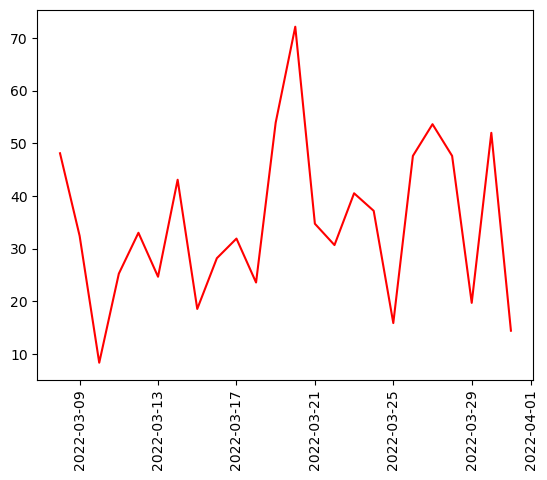

In [28]:
import matplotlib.pyplot as plt
t_wrong_sched= [] 


for i in range(0,24):
    t_wrong_sched.append(results[i]['t_wrong_sched_%'])
plt.plot(predict_day[0:24],t_wrong_sched,'r')
plt.xticks(rotation=90)


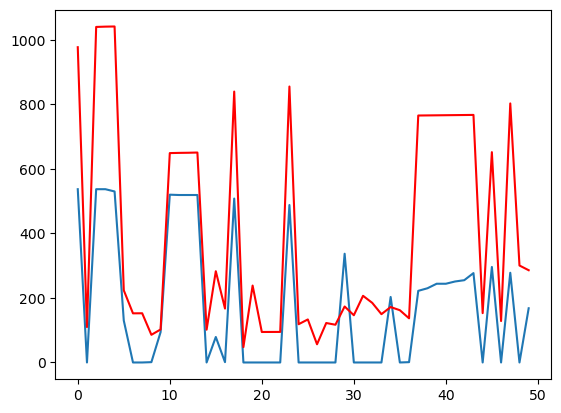

In [29]:
import matplotlib.pyplot as plt
plt.plot(df_predict['day11']['queue_minutes'].to_numpy()[150:200])
plt.plot(results[10]['y_pred'][150:200],'r')

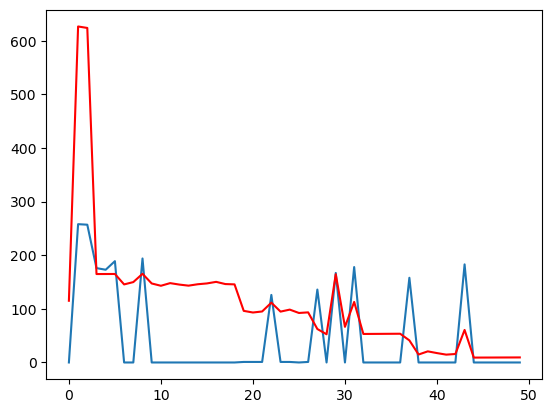

In [30]:
plt.plot(df_predict['day11']['queue_minutes'].to_numpy()[200:250])
plt.plot(results[10]['y_pred'][200:250],'r')

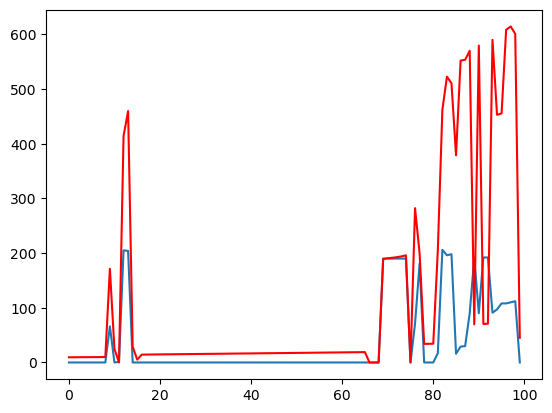

In [31]:
plt.plot(df_predict['day11']['queue_minutes'].to_numpy()[250:350])
plt.plot(results[10]['y_pred'][250:350],'r')

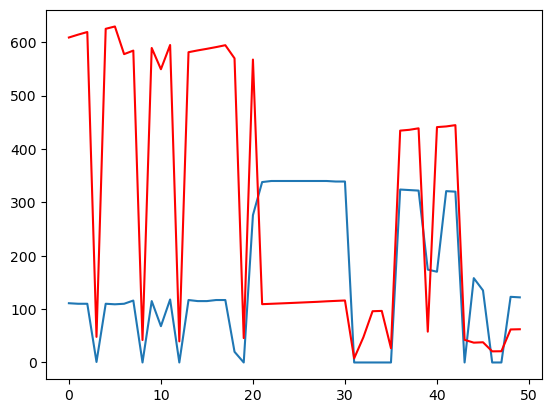

In [32]:
plt.plot(df_predict['day11']['queue_minutes'].to_numpy()[350:400])
plt.plot(results[10]['y_pred'][350:400],'r')

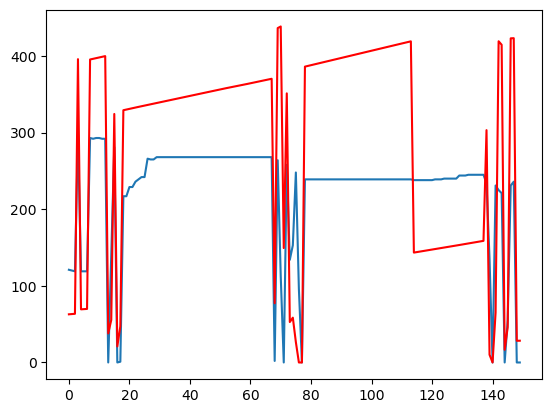

In [33]:
plt.plot(df_predict['day11']['queue_minutes'].to_numpy()[400:550])
plt.plot(results[10]['y_pred'][400:550],'r')

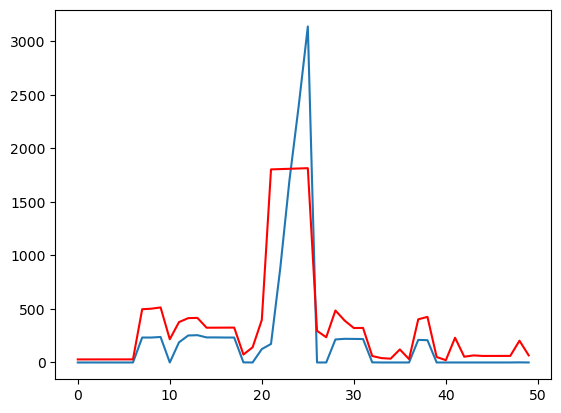

In [34]:
plt.plot(df_predict['day11']['queue_minutes'].to_numpy()[550:600])
plt.plot(results[10]['y_pred'][550:600],'r')

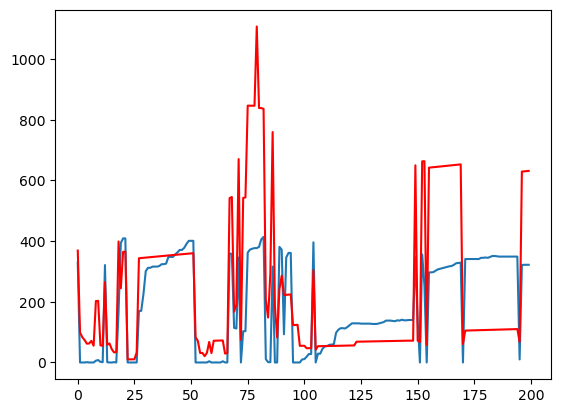

In [35]:
plt.plot(df_predict['day11']['queue_minutes'].to_numpy()[600:800])
plt.plot(results[10]['y_pred'][600:800],'r')

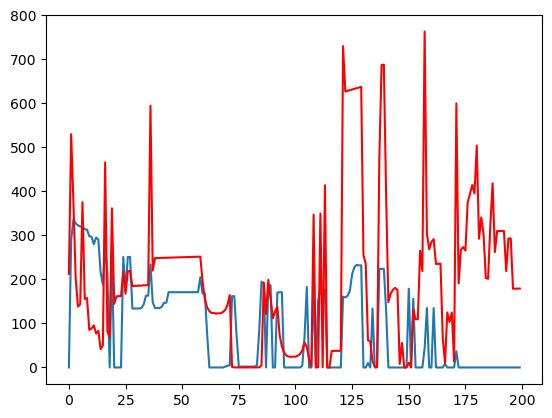

In [36]:
plt.plot(df_predict['day12']['queue_minutes'].to_numpy()[0:200])
plt.plot(results[11]['y_pred'][0:200],'r')

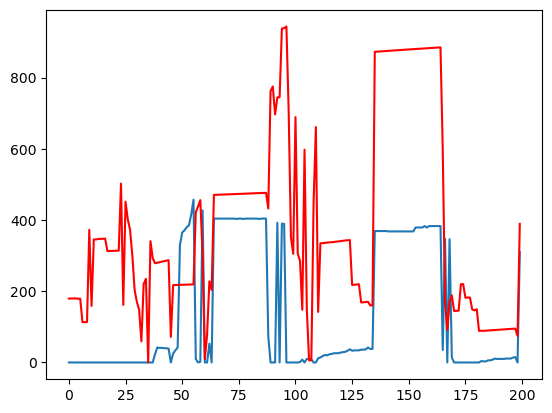

In [37]:
plt.plot(df_predict['day12']['queue_minutes'].to_numpy()[200:400])
plt.plot(results[11]['y_pred'][200:400],'r')

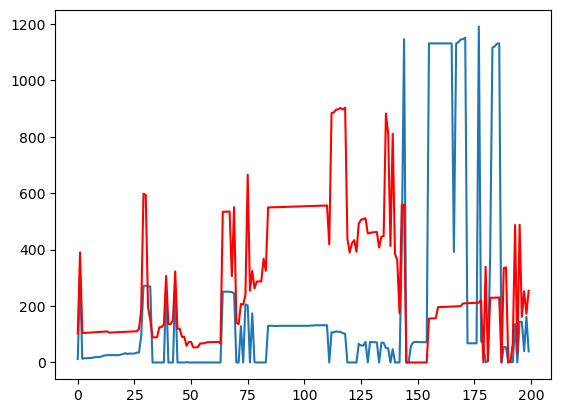

In [38]:
plt.plot(df_predict['day12']['queue_minutes'].to_numpy()[400:600])
plt.plot(results[11]['y_pred'][400:600],'r')

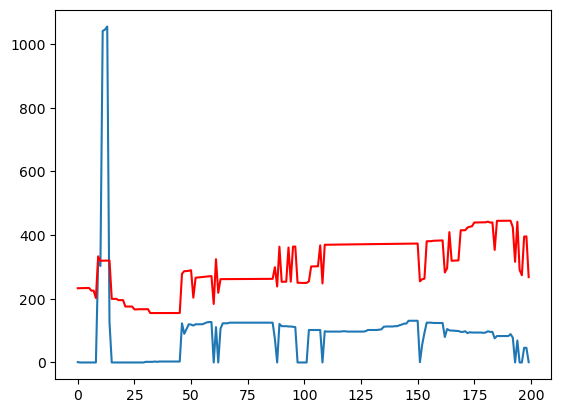

In [39]:
plt.plot(df_predict['day13']['queue_minutes'].to_numpy()[0:200])
plt.plot(results[12]['y_pred'][0:200],'r')

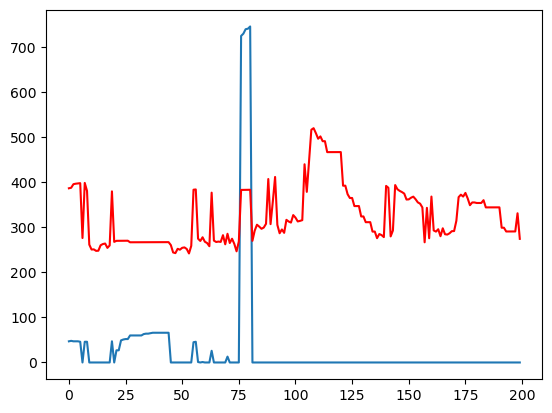

In [40]:
plt.plot(df_predict['day13']['queue_minutes'].to_numpy()[200:400])
plt.plot(results[12]['y_pred'][200:400],'r')

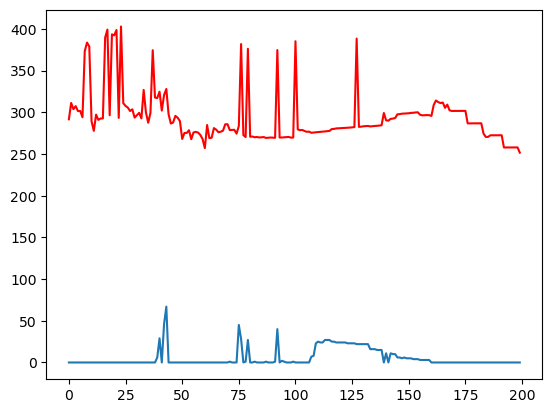

In [41]:
plt.plot(df_predict['day13']['queue_minutes'].to_numpy()[400:600])
plt.plot(results[12]['y_pred'][400:600],'r')

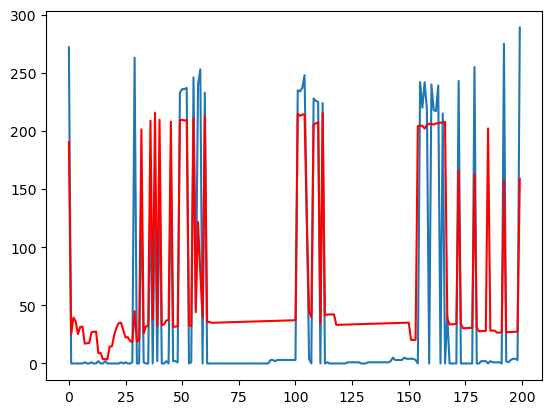

In [42]:
plt.plot(df_predict['day24']['queue_minutes'].to_numpy()[0:200])
plt.plot(results[23]['y_pred'][0:200],'r')